In [64]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib  # for saving/loading model

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


In [65]:
df = pd.read_excel('Data/test_Battle_Royale.csv.xlsx')

categorical_cols = ['Role', 'Tier', 'ActivityStatus']
numerical_cols = ['Experience', 'Level', 'Achievements', 'KD']

df[categorical_cols] = df[categorical_cols].fillna('Unknown')
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())


In [66]:
condition1 = (df['ActivityStatus'] == 'Returner') & (df['Tier'].isin(['Legend', 'Dominator', 'Conqueror']))

condition2 = (df['Experience'] <= 3) & (df['Achievements'] > 5000)

df['FalseEntry'] = (condition1 | condition2)


In [67]:
valid_df = df[~df['FalseEntry']].copy()

In [68]:
def predict_survival(row):
    if (row['KD'] <= 5) and (row['ActivityStatus'] in ['Returner', 'Casual']) and (row['Tier'] in ['Gold', 'Platinum', 'Diamond']):
        return '<10min'
    elif (3 < row['KD'] <= 10) and (row['Tier'] in ['Diamond', 'Crown']):
        return '<20min'
    elif (8 <= row['KD'] <= 15) and (row['ActivityStatus'] in ['Regular', 'Casual']) and (row['Tier'] in ['Ace', 'Dominator', 'Legend', 'Conqueror']):
        return '<30min'
    else:
        return 'Uncertain'

valid_df['SurvivalTime'] = valid_df.apply(predict_survival, axis=1)


In [69]:
false_entries = df[df['FalseEntry']]
false_entries.head()

,Server,Mode,PlayerName,Role,Experience,Level,Tier,ActivityStatus,Achievements,KD,FalseEntry
13,Asia,Solo,RogueDestroyer553,Unknown,3.6,80.0,Dominator,Returner,6812.0,8.33,True
15,America,Squad,DeadlyNinja898,Unknown,2.5,63.0,Gold,Regular,6874.0,8.17,True
18,Europe,Solo,FatalHunter723,IGL,1.1,54.0,Ace,Regular,7910.0,8.17,True
20,America,Duo,DarkCommando961,Assaulter,2.6,67.0,Platinum,Regular,6812.0,5.16,True
26,America,Squad,FatalBerserk727,Assaulter,1.7,77.0,Ace,Regular,8037.0,8.17,True


In [70]:
df['LegendPlayer'] = (df['Experience'] >= 6) & (df['Achievements'] >= 7000)
df['UltimateLegend'] = df['LegendPlayer'] & (df['ActivityStatus'] == 'Returner')

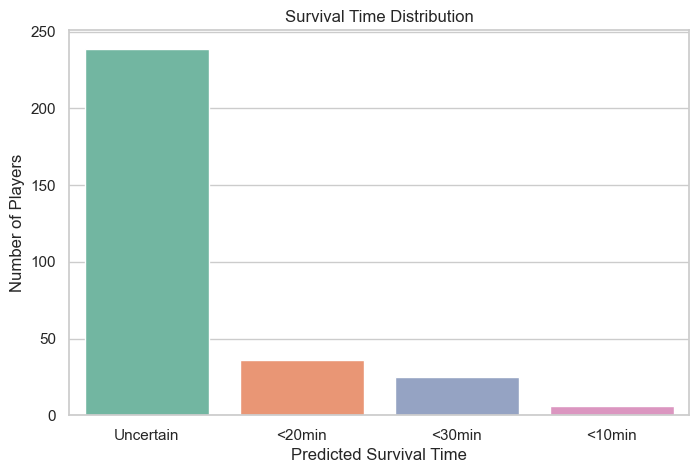

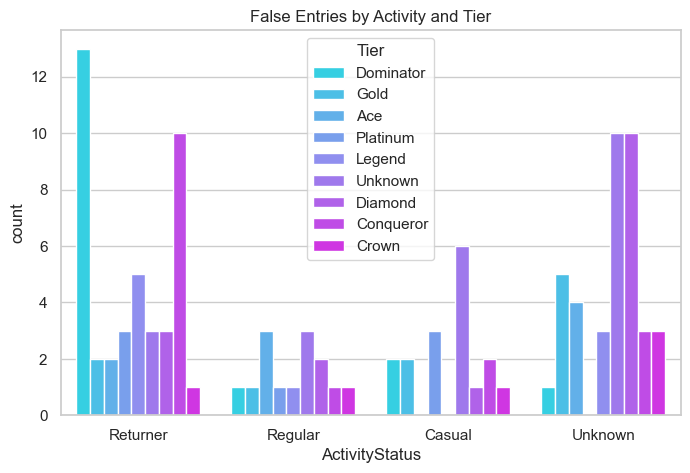

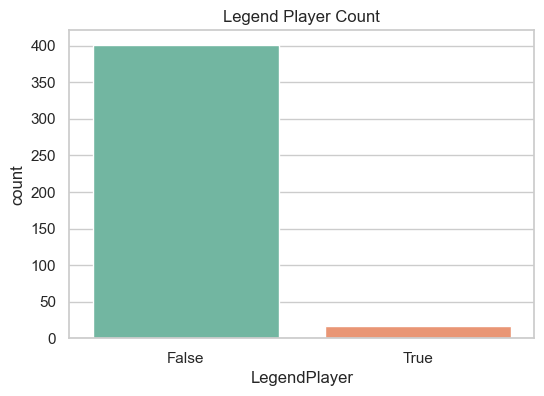

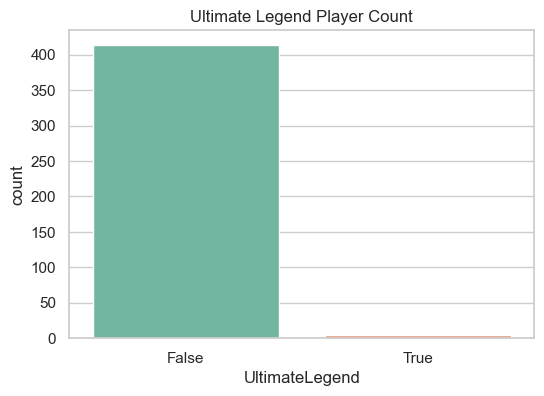

In [71]:
# Graph for Survival Time distribution
plt.figure(figsize=(8,5))
sns.countplot(data=valid_df, x='SurvivalTime', hue='SurvivalTime', palette='Set2', legend=False)
plt.title("Survival Time Distribution")
plt.xlabel("Predicted Survival Time")
plt.ylabel("Number of Players")
plt.show()

# Graph: FALSE Entries 
plt.figure(figsize=(8,5))
sns.countplot(data=df[df['FalseEntry']], x='ActivityStatus', hue='Tier', palette='cool')
plt.title("False Entries by Activity and Tier")
plt.show()

# Graph: Legend Players
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='LegendPlayer', hue='LegendPlayer', palette='Set2', legend=False)
plt.title("Legend Player Count")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='UltimateLegend', hue='UltimateLegend', palette='Set2', legend=False)
plt.title("Ultimate Legend Player Count")
plt.show()


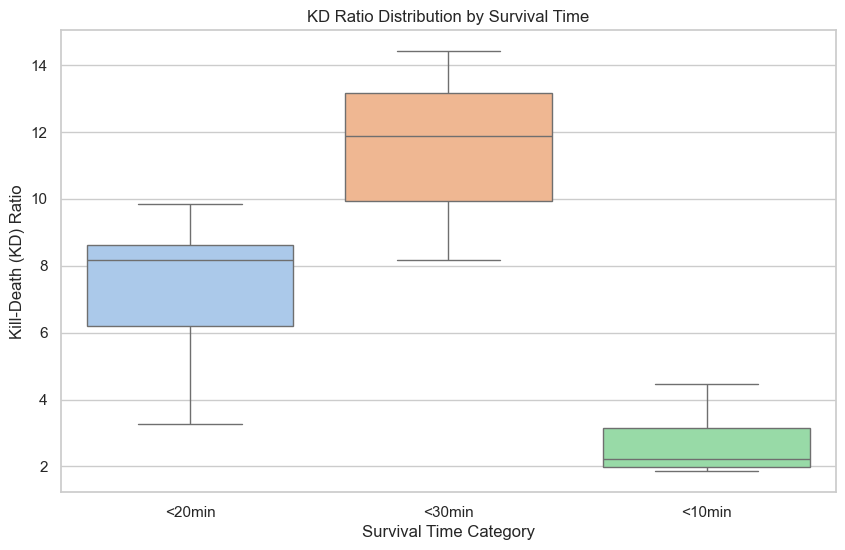

In [72]:
# Visualization of KD vs Survival Time
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='SurvivalTime', y='KD', palette='pastel')
plt.title("KD Ratio Distribution by Survival Time")
plt.xlabel("Survival Time Category")
plt.ylabel("Kill-Death (KD) Ratio")
plt.show()


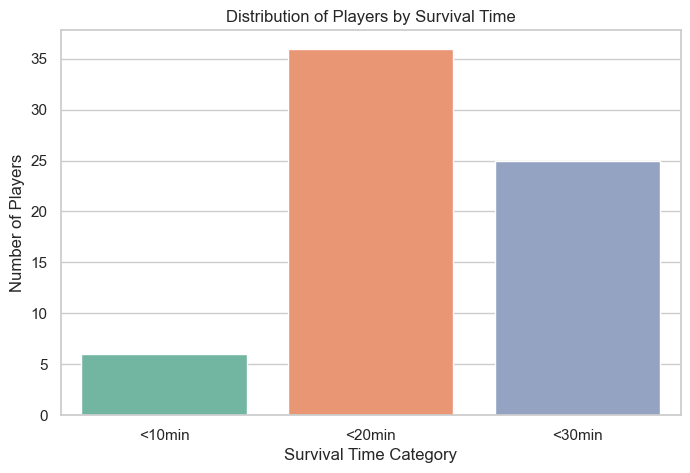

In [62]:
#Counting how many players are in <10min, <20min, <30min
survival_counts = valid_df['SurvivalTime'].value_counts().reindex(['<10min', '<20min', '<30min'], fill_value=0)
plt.figure(figsize=(8,5))
sns.barplot(x=survival_counts.index, y=survival_counts.values, palette='Set2')
plt.title("Distribution of Players by Survival Time")
plt.xlabel("Survival Time Category")
plt.ylabel("Number of Players")
plt.show()


Accuracy: 0.9285714285714286

Classification Report:
               precision    recall  f1-score   support

      <10min       1.00      0.50      0.67         2
      <20min       0.89      1.00      0.94         8
      <30min       1.00      1.00      1.00         4

    accuracy                           0.93        14
   macro avg       0.96      0.83      0.87        14
weighted avg       0.94      0.93      0.92        14



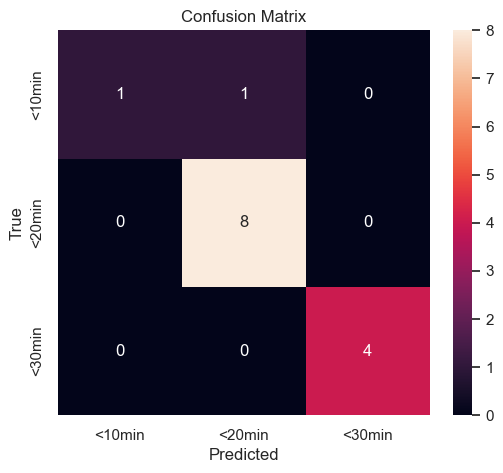

In [73]:
#Filter out 'Uncertain' classes
train_df = valid_df[valid_df['SurvivalTime'] != 'Uncertain'].copy()

#Label encode target
le = LabelEncoder()
train_df['SurvivalTimeLabel'] = le.fit_transform(train_df['SurvivalTime'])  # <10min = 0, <20min = 1, <30min = 2

#Encoding categorical variables
encoded_df = pd.get_dummies(train_df[['Server', 'Mode', 'Role', 'Tier', 'ActivityStatus']], drop_first=True)

X = pd.concat([train_df[['Experience', 'Level', 'Achievements', 'KD']], encoded_df], axis=1)
y = train_df['SurvivalTimeLabel']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Training Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

#Predictions
y_pred = clf.predict(X_test)

#Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

#Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
